# **Laboratorio 3 - SIS421** 

**CNN con Modelo Preentrenado DeiT Small**

Arancibia Aguilar Daniel Andree

Ingeniería en Ciencias de la Computación

Para este laboratorio haremos uso de un modelo preeentrenado elegido, con el que aplicaremos las tecnicas de transfer learning y fine tuning

El modelo que elgi es DeiT Small (Data-efficient Image Transformer), que fue entrenado con ImageNet-1k, a una resolución de 224x224 píxeles

Tiene una arquitectura de 12 capas de transformadores el cual contiene 22 millones de parámetros haciendolo ligero en comparación con otros

**Importación de librerias**

In [19]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
#Importamos timm para poder importar el modelo preentrenado
import timm

## **Exploracion de datos**

In [23]:
#usaremos la GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Tranformamos el dataset, como fue entrenado a 224x224 reescalaremos las imagenes de nuestro dataset a esa resolución
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

#dataset_path = "E:/LAB3SIS421/DATASETCONVOLUCIONAL"
dataset_path = "E:/LAB3SIS421/DATASETPLANTAS"
dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=transform)

#Separar en entrenamiento y prueba
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

#Imprimir los tamaños del dataset, del entrenamiento y de la prueba
print(f"Tamaño total del dataset: {len(dataset)}")
print(f"Tamaño del conjunto de entrenamiento: {len(train_dataset)}")
print(f"Tamaño del conjunto de prueba: {len(test_dataset)}")

#Crear DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Tamaño total del dataset: 10000
Tamaño del conjunto de entrenamiento: 8000
Tamaño del conjunto de prueba: 2000


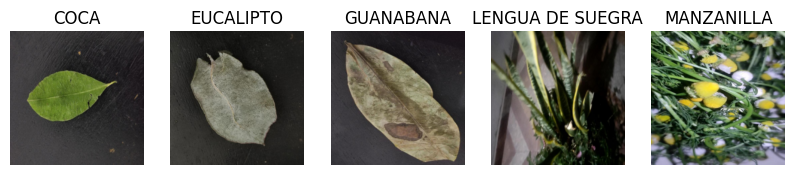

In [24]:
#Mostrar una imagen de cada clase
class_names = dataset.classes
images_shown = {class_name: False for class_name in class_names}

plt.figure(figsize=(10, 10))

for images, labels in train_loader:
    for i in range(labels.size(0)):
        label = labels[i].item()
        class_name = class_names[label]
        if not images_shown[class_name]:
            image = images[i].permute(1, 2, 0).cpu().numpy()  # Cambiar la dimensión de imagen para matplotlib
            plt.subplot(1, len(class_names), label + 1)
            plt.imshow(image)
            plt.title(class_name)
            plt.axis('off')
            images_shown[class_name] = True
            
        if all(images_shown.values()):
            break
    if all(images_shown.values()):
        break

plt.show()

Se usara el dataset de 10k imagenes para la presentación debido al tiempo que requiere entrenar con el dataset de 75k imagenes

## **Entrenando desde 0**

In [3]:
# Definir la clase ModelCustom para usar DeiT Small
class ModelCustom(torch.nn.Module):
    def __init__(self, n_outputs=5, pretrained=False, freeze=False):
        super().__init__()
        # Cargar el modelo DeiT Small
        self.deit_small = timm.create_model('deit_small_patch16_224', pretrained=pretrained)
        # Reemplazar la capa de clasificación final
        self.deit_small.head = torch.nn.Linear(self.deit_small.head.in_features, n_outputs)
        
        if freeze:
            for param in self.deit_small.parameters():
                param.requires_grad = False
        
    def forward(self, x):
        return self.deit_small(x)

    def unfreeze(self):
        for param in self.deit_small.parameters():
            param.requires_grad = True

In [4]:
# Crear el modelo
model_c = ModelCustom(pretrained=False, freeze=False)
model_c.to(device)

ModelCustom(
  (deit_small): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='no

In [5]:
def fit(model, dataloader, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            # Calcular precisión
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_accuracy = correct_predictions / total_predictions
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

In [6]:
# Entrenar el modelo
fit(model_c, train_loader, epochs=15)

e:\LAB3SIS421\env\Lib\site-packages\timm\models\vision_transformer.py:92: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  x = F.scaled_dot_product_attention(


Epoch [1/15], Loss: 1.7245, Accuracy: 0.2224
Epoch [2/15], Loss: 1.3471, Accuracy: 0.3977
Epoch [3/15], Loss: 1.0457, Accuracy: 0.5379
Epoch [4/15], Loss: 1.0292, Accuracy: 0.5509
Epoch [5/15], Loss: 0.8264, Accuracy: 0.6605
Epoch [6/15], Loss: 0.7447, Accuracy: 0.7026
Epoch [7/15], Loss: 0.6278, Accuracy: 0.7582
Epoch [8/15], Loss: 0.5377, Accuracy: 0.7939
Epoch [9/15], Loss: 0.4430, Accuracy: 0.8376
Epoch [10/15], Loss: 0.3951, Accuracy: 0.8518
Epoch [11/15], Loss: 0.3903, Accuracy: 0.8531
Epoch [12/15], Loss: 0.4148, Accuracy: 0.8424
Epoch [13/15], Loss: 0.4346, Accuracy: 0.8297
Epoch [14/15], Loss: 0.4061, Accuracy: 0.8440
Epoch [15/15], Loss: 0.4172, Accuracy: 0.8354


Como podemos ver el modelo tarda en aprender y aun tiene bastante error, ya que lo estamos entrenando desde 0

## **Transfer Learning**

In [27]:
# Definir la clase ModelCustom para usar DeiT Small
class ModelCustom(torch.nn.Module):
    def __init__(self, n_outputs=5, pretrained=True, freeze=True):
        super().__init__()
        # Cargar el modelo DeiT Small
        self.deit_small = timm.create_model('deit_small_patch16_224', pretrained=pretrained)
        # Reemplazar la capa de clasificación final
        self.deit_small.head = torch.nn.Linear(self.deit_small.head.in_features, n_outputs)
        
        if freeze:
            # Congelar todas las capas menos la capa final
            for name, param in self.deit_small.named_parameters():
                if 'head' not in name:
                    param.requires_grad = False
        else:
            # Asegurarse de que todas las capas están entrenables
            for param in self.deit_small.parameters():
                param.requires_grad = True
        
    def forward(self, x):
        return self.deit_small(x)

    def unfreeze(self):
        for param in self.deit_small.parameters():
            param.requires_grad = True


In [8]:
# Crear el modelo
model_c = ModelCustom(pretrained=True, freeze=True)
model_c.to(device)


ModelCustom(
  (deit_small): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='no

In [17]:
# Función de entrenamiento con precisión
def fit(model, dataloader, optimizer, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            # Calcular precisión
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_accuracy = correct_predictions / total_predictions
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')


In [10]:
# Entrenar el modelo
fit(model_c, train_loader, epochs=15)

Epoch [1/15], Loss: 0.4449, Accuracy: 0.8835
Epoch [2/15], Loss: 0.1518, Accuracy: 0.9706
Epoch [3/15], Loss: 0.0995, Accuracy: 0.9834
Epoch [4/15], Loss: 0.0755, Accuracy: 0.9880
Epoch [5/15], Loss: 0.0607, Accuracy: 0.9896
Epoch [6/15], Loss: 0.0503, Accuracy: 0.9924
Epoch [7/15], Loss: 0.0431, Accuracy: 0.9936
Epoch [8/15], Loss: 0.0375, Accuracy: 0.9948
Epoch [9/15], Loss: 0.0332, Accuracy: 0.9959
Epoch [10/15], Loss: 0.0297, Accuracy: 0.9962
Epoch [11/15], Loss: 0.0265, Accuracy: 0.9964
Epoch [12/15], Loss: 0.0240, Accuracy: 0.9972
Epoch [13/15], Loss: 0.0220, Accuracy: 0.9978
Epoch [14/15], Loss: 0.0199, Accuracy: 0.9982
Epoch [15/15], Loss: 0.0182, Accuracy: 0.9991


A diferencia del entrenamiento anterior, con transfer learning conseguimos una gran precision casi desde el primer momento ademas de que el tiempo de entrenamiento se redujo bastante

## **Fine Tuning**

In [11]:
model_c = ModelCustom(pretrained=True, freeze=False)
model_c.to(device)

ModelCustom(
  (deit_small): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='no

In [12]:
# Entrenar el modelo
fit(model_c, train_loader, epochs=15)

Epoch [1/15], Loss: 1.0751, Accuracy: 0.5436
Epoch [2/15], Loss: 0.3762, Accuracy: 0.8571
Epoch [3/15], Loss: 0.1724, Accuracy: 0.9389
Epoch [4/15], Loss: 0.0826, Accuracy: 0.9710
Epoch [5/15], Loss: 0.0842, Accuracy: 0.9732
Epoch [6/15], Loss: 0.0819, Accuracy: 0.9732
Epoch [7/15], Loss: 0.0634, Accuracy: 0.9779
Epoch [8/15], Loss: 0.0329, Accuracy: 0.9895
Epoch [9/15], Loss: 0.0264, Accuracy: 0.9914
Epoch [10/15], Loss: 0.0542, Accuracy: 0.9809
Epoch [11/15], Loss: 0.0501, Accuracy: 0.9841
Epoch [12/15], Loss: 0.0288, Accuracy: 0.9904
Epoch [13/15], Loss: 0.0087, Accuracy: 0.9970
Epoch [14/15], Loss: 0.0739, Accuracy: 0.9760
Epoch [15/15], Loss: 0.0344, Accuracy: 0.9891


Aca teniendo las capas sin congelar tenemos menos precision inicial, sin embargo el aprendizaje es bastante rapido

## **Entrenamiento con diferentes Learning rates**

In [18]:
# Crear el modelo con capas base congeladas
model_o = ModelCustom(pretrained=True, freeze=True)
model_o.to(device)

# Separar los parámetros de la cabeza (head) y el resto del modelo
head_params = list(model_o.deit_small.head.parameters())
base_params = [param for name, param in model_o.deit_small.named_parameters() if 'head' not in name]

# Definir el optimizador con diferentes learning rates
optimizer = torch.optim.Adam([
    {'params': base_params, 'lr': 1e-4},
    {'params': head_params, 'lr': 1e-3}
])
# Primer entrenamiento con capas base congeladas
fit(model_o, train_loader, optimizer, epochs=5)

Epoch [1/5], Loss: 0.4805, Accuracy: 0.8689
Epoch [2/5], Loss: 0.1583, Accuracy: 0.9712
Epoch [3/5], Loss: 0.1039, Accuracy: 0.9830
Epoch [4/5], Loss: 0.0786, Accuracy: 0.9865
Epoch [5/5], Loss: 0.0631, Accuracy: 0.9902


Con las diferentes pruebas pudimos ver que el transfer learning es el mas optimo al usar un modelo preentrenado 